# Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

## Домашнее задание

1. *Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
3. Повторить п.2, но используя уже не медиану, а max
4. *Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
    - подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
    - подсказка 2: нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Дополнительные ссылки 
1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
3. http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [1]:
import pandas as pd

Наши новости

https://drive.google.com/file/d/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

--2023-06-12 18:47:10--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Распознаётся docs.google.com (docs.google.com)… 2a00:1450:4028:803::200e, 172.217.22.78
Подключение к docs.google.com (docs.google.com)|2a00:1450:4028:803::200e|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7tr952djl38hhqt0tk22q673ql55329c/1686584775000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=07ad51b3-a510-4fc7-8007-8f7c8deabfe3 [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-06-12 18:47:11--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7tr952djl38hhqt0tk22q673ql55329c/1686584775000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=07ad51b3-a510-4fc7-8007-8f7c8deabfe3
Распознаётся doc-0s-c0-docs.googleusercontent.com 

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
# news.iloc[0]['title']

Ссылка на google диск https://drive.google.com/file/d/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a

In [5]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2023-06-12 18:47:19--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Распознаётся drive.google.com (drive.google.com)… 2a00:1450:4028:801::200e, 142.251.142.206
Подключение к drive.google.com (drive.google.com)|2a00:1450:4028:801::200e|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uoqsauoe5s9qt4jcgo9psr5oo40csn9u/1686584775000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download&uuid=8187f64b-8ee6-4bcf-810e-173738f17cfc [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-06-12 18:47:20--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uoqsauoe5s9qt4jcgo9psr5oo40csn9u/1686584775000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download&uuid=8187f64b-8ee6-4bcf-810e-173738f17cfc
Распознаётся doc-04-c0-docs.googleusercontent.com (do

Загрузим пользователей и списки последних прочитанных новостей

In [6]:
users = pd.read_csv("users_articles.csv")
# users.head(3)

Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

**ПОЗАВТРАКАЛИ**

Стемминг (убираем лишнии куски слова):
**завтрак**<br>
Очень быстро, очень дешево и очень слабо.

Лемматизация (перевод в неопределенную форму для гл. и в им.падеж для сущ.):
**позавтракать**<br>
Небыстро, сложно.

In [7]:
!/Users/lmv/opt/anaconda3/envs/nlp/bin/pip3 install razdel pymorphy2

zsh:1: no such file or directory: /Users/lmv/opt/anaconda3/envs/nlp/bin/pip3


In [8]:
!pip install gensim

In [9]:
!pip install razdel

In [10]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

Не все слова равны, не все слова одинаково работают. К примеру, союзы и предлоги в нашей задачи никак не помогут, поэтому можем их выкидывать. (*Но в задачах оценки стиля, к примеру, такие слова будут очень полезны*)

In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annvorosh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [13]:
# stopword_ru[:10]

In [14]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2023-06-12 18:47:25--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Распознаётся drive.google.com (drive.google.com)… 2a00:1450:4028:801::200e, 142.251.142.206
Подключение к drive.google.com (drive.google.com)|2a00:1450:4028:801::200e|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5ieaofar86kah6sp0kpm5uqaql8jhne2/1686584775000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=7fcc2a37-0433-41e1-a2ad-b9aeaa611f07 [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-06-12 18:47:26--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5ieaofar86kah6sp0kpm5uqaql8jhne2/1686584775000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=7fcc2a37-0433-41e1-a2ad-b9aeaa611f07
Распознаётся doc-0s-c0-docs.googleusercontent.com (do

In [15]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [16]:
# stopword_ru[200:210]

In [17]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [18]:
morph = pymorphy2.MorphAnalyzer()
# morph.parse('сбегали')[0].normal_form

In [19]:
morph = pymorphy2.MorphAnalyzer()
# morph.parse('стали')

In [20]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|                                                 | 0/27000 [00:00<?, ?it/s]/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_60500/4083466619.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|███████████████████████████████████| 27000/27000 [00:18<00:00, 1447.26it/s]

CPU times: user 18.5 s, sys: 141 ms, total: 18.7 s
Wall time: 18.7 s


In [21]:
news['title'].iloc[:2]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [22]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [23]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████| 27000/27000 [02:03<00:00, 218.67it/s]

CPU times: user 2min 3s, sys: 417 ms, total: 2min 3s
Wall time: 2min 3s


А теперь в 3 строчки обучим нашу модель

In [24]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [25]:
len(common_dictionary)

135645

In [26]:
# common_dictionary[5]

In [27]:
# common_dictionary.id2token

In [28]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(993, 1), (6129, 1), (12270, 1), (135645, 1)]

In [29]:
len(common_dictionary)

135646

In [30]:
common_dictionary[6129]

'чай'

Все просто - это словарь наших слов

Запускаем обучение

In [31]:
N_topic = 25

In [32]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=10)

CPU times: user 4min 30s, sys: 7min 48s, total: 12min 18s
Wall time: 2min 34s


In [33]:
#common_corpus

In [34]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [35]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [36]:
# Создаем новый корпус документов
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(7, 0.13162461),
 (9, 0.02882283),
 (10, 0.642596),
 (14, 0.12194916),
 (16, 0.027498918),
 (19, 0.02739772)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [37]:
x = lda.show_topics(num_topics=N_topic, num_words=15, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: млн европа соглашение европейский германия долг инвестиция турецкий сделка актив договор тыс контракт сторона писать
topic_1: россия российский глава государство власть министр путин владимир правительство вопрос рф наука сторона безопасность решение
topic_2: директор медведев александр совет дмитрий николай пост риа новость сергей алексей андрей михаил председатель гендиректор
topic_3: день вода температура британский пенсия продукция рейс воздух великобритания дональд неделя погода давление фон вскоре
topic_4: операция турция атака террорист боевик огонь запретить уничтожить объект противник ирак сбить освобождение компьютерный гражданство
topic_5: фильм зима кухня рот ле людмила чашка определяться оригинальный разочарование оксана ноябрьский наталия эммануэль констатировать
topic_6: снижение поверхность снизить зарегистрировать резерв рт испания отреагировать испанский гагарин инвестировать уверять вадим молдавия сибирский
topic_7: всё исследование новый случай очень пробле

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [38]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [39]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.01374244, 0.44422486, 0.22785181, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.14101487,
       0.13793324, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.027552  ])

In [40]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 23.3 s, sys: 36.4 s, total: 59.7 s
Wall time: 12.4 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.013741,0.444283,0.22785,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.027492
1,4896,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.073584,0.0,0.0,0.0,0.000000
2,4897,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.131648,0.0,...,0.0,0.027499,0.0,0.0,0.027398,0.000000,0.0,0.0,0.0,0.000000
3,4898,0.000000,0.121339,0.00000,0.0,0.0,0.0,0.0,0.537231,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,4899,0.209860,0.000000,0.36820,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.146149


In [41]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.013741,0.444283,0.22785,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.027492
1,4896,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.073584,0.0,0.0,0.0,0.000000
2,4897,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.131648,0.0,...,0.0,0.027499,0.0,0.0,0.027398,0.000000,0.0,0.0,0.0,0.000000
3,4898,0.000000,0.121339,0.00000,0.0,0.0,0.0,0.0,0.537231,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,4899,0.209860,0.000000,0.36820,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.146149


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [42]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [43]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [44]:
doc_dict[293672]

array([0.        , 0.35275248, 0.        , 0.        , 0.        ,
       0.        , 0.02889514, 0.067481  , 0.07869504, 0.130918  ,
       0.        , 0.        , 0.04035471, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.28088719, 0.        ])

### Mean

In [45]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [46]:
# user_articles_list = users['articles'].iloc[33]

# get_user_embedding(user_articles_list, doc_dict)

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [47]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 246 ms, sys: 7.65 ms, total: 253 ms
Wall time: 250 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.027391,0.177442,0.000000,0.012940,0.010758,0.00000,0.004816,0.100612,0.040093,...,0.095681,0.003093,0.007889,0.015044,0.0,0.038353,0.00827,0.022352,0.084074,0.055969
1,u108690,0.040143,0.219364,0.005136,0.009677,0.000000,0.00364,0.000000,0.194198,0.035894,...,0.059518,0.001826,0.000000,0.021835,0.0,0.057842,0.01240,0.002230,0.035239,0.074977
2,u108339,0.028681,0.193400,0.007469,0.046675,0.008327,0.00000,0.002130,0.108154,0.025030,...,0.084929,0.001722,0.011090,0.024112,0.0,0.010870,0.00000,0.004967,0.097075,0.119816


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

https://drive.google.com/file/d/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK

In [48]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2023-06-12 18:52:42--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Распознаётся drive.google.com (drive.google.com)… 2a00:1450:4028:809::200e, 142.251.37.78
Подключение к drive.google.com (drive.google.com)|2a00:1450:4028:809::200e|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eusslgsf1snig2i6nvts3hj3f42dj67q/1686585150000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=567bf639-3d04-4f8b-80a0-ee2dc0f36a6f [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-06-12 18:52:43--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eusslgsf1snig2i6nvts3hj3f42dj67q/1686585150000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=567bf639-3d04-4f8b-80a0-ee2dc0f36a6f
Распознаётся doc-0k-c0-docs.googleusercontent.com (doc-

In [49]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [50]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.027391,0.177442,0.000000,0.012940,0.010758,0.00000,0.004816,0.100612,0.040093,...,0.003093,0.007889,0.015044,0.0,0.038353,0.00827,0.022352,0.084074,0.055969,0
1,u108690,0.040143,0.219364,0.005136,0.009677,0.000000,0.00364,0.000000,0.194198,0.035894,...,0.001826,0.000000,0.021835,0.0,0.057842,0.01240,0.002230,0.035239,0.074977,1
2,u108339,0.028681,0.193400,0.007469,0.046675,0.008327,0.00000,0.002130,0.108154,0.025030,...,0.001722,0.011090,0.024112,0.0,0.010870,0.00000,0.004967,0.097075,0.119816,1


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [52]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, stratify=X['churn'], 
                                                    test_size=0.25)

In [53]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [54]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.04978042, 0.20689595, 0.01153836, 0.01611389, 0.0229444 ,
       0.08308911, 0.06914088, 0.09138179, 0.03605195, 0.00473222,
       0.00113531, 0.06989486, 0.16412192, 0.06950355, 0.25257743,
       0.12035291, 0.00487345, 0.0256931 , 0.04007263, 0.05446049])

### Рассчитаем Precision, Recall, F_score

In [55]:

thresholds_arr = []
fscore_arr = []
precision_arr = []
recall_arr = []
cnf_matrix_arr = []
roc_auc_score_arr = []

In [56]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

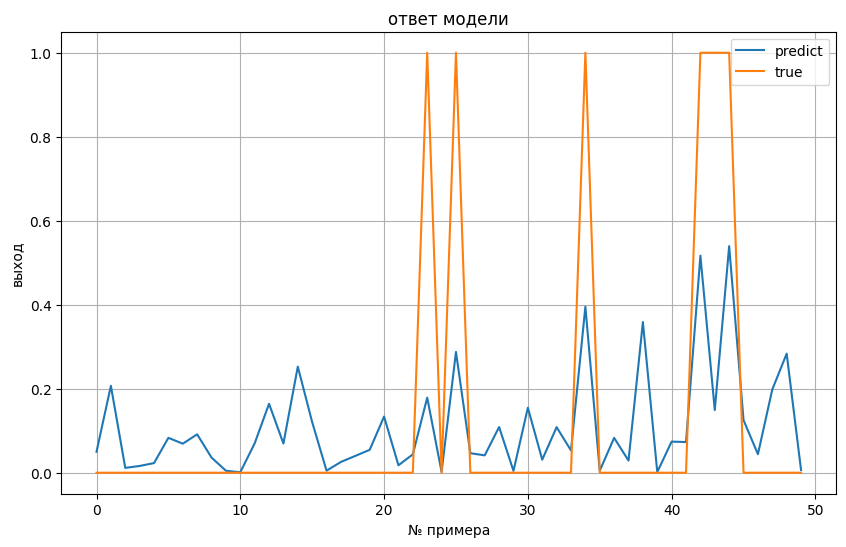

In [57]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3053607299540598, F-Score=0.702, Precision=0.722, Recall=0.684


In [59]:
thresholds_arr.append(thresholds[ix])
fscore_arr.append(fscore[ix])
precision_arr.append(precision[ix])
recall_arr.append(recall[ix])

thresholds_arr, fscore_arr, precision_arr, recall_arr

([0.3053607299540598], [0.7022587268993841], [0.7215189873417721], [0.684])

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1684   66]
 [  80  170]]


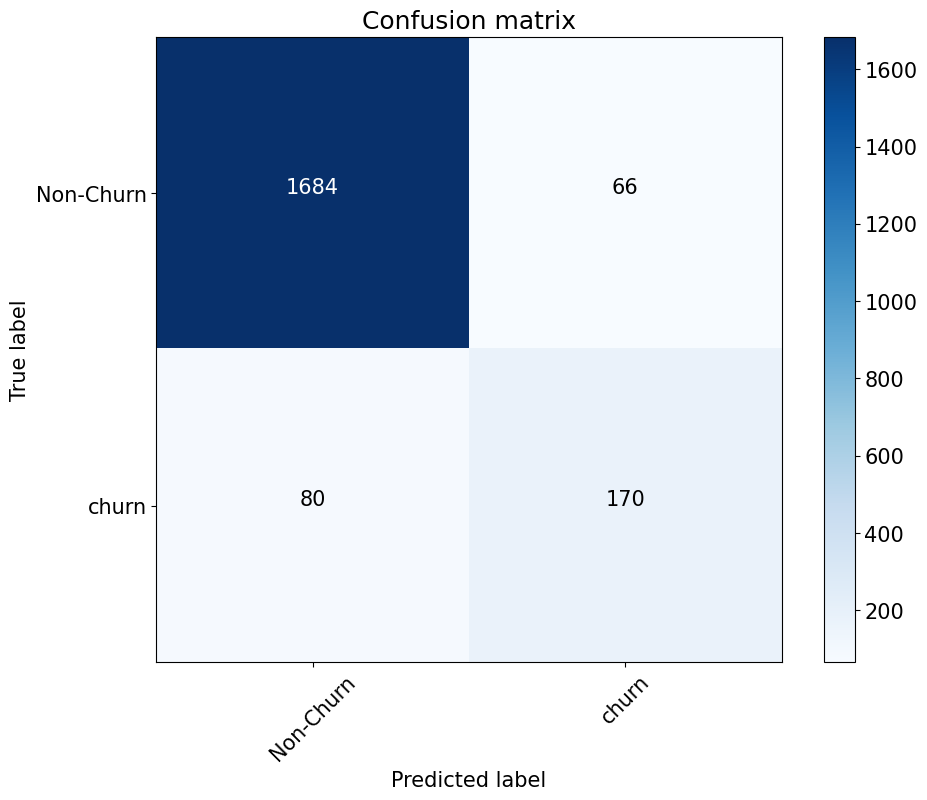

In [61]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [62]:
roc_auc_score(y_test, preds)

0.9593005714285715

In [63]:
# Добавление значений в массивы

cnf_matrix_arr.append(cnf_matrix)
roc_auc_score_arr.append(roc_auc_score(y_test, preds))

cnf_matrix_arr, roc_auc_score_arr

([array([[1684,   66],
         [  80,  170]])],
 [0.9593005714285715])

### Median

In [64]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  
    return user_vector

In [65]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 389 ms, sys: 14.3 ms, total: 404 ms
Wall time: 360 ms


In [66]:
X = pd.merge(user_embeddings, target, 'left')

In [67]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, stratify=X['churn'], 
                                                    test_size=0.25)

In [68]:
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [69]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.09745453, 0.12986657, 0.00303125, 0.02378402, 0.03761345,
       0.08930344, 0.03976556, 0.06755099, 0.04981845, 0.01002892,
       0.00168293, 0.19545682, 0.12214362, 0.09168095, 0.11898531,
       0.16533124, 0.00244551, 0.03126742, 0.02544871, 0.03893547])

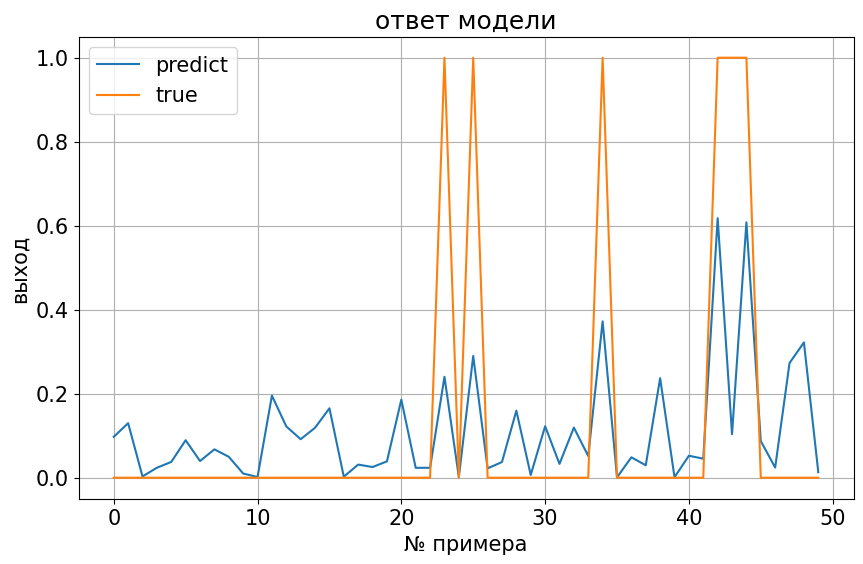

In [70]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [71]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2752140737806895, F-Score=0.737, Precision=0.678, Recall=0.808


In [72]:
thresholds_arr.append(thresholds[ix])
fscore_arr.append(fscore[ix])
precision_arr.append(precision[ix])
recall_arr.append(recall[ix])

thresholds_arr, fscore_arr, precision_arr, recall_arr

([0.3053607299540598, 0.2752140737806895],
 [0.7022587268993841, 0.7372262773722629],
 [0.7215189873417721, 0.6778523489932886],
 [0.684, 0.808])

Confusion matrix, without normalization
[[1654   96]
 [  49  201]]


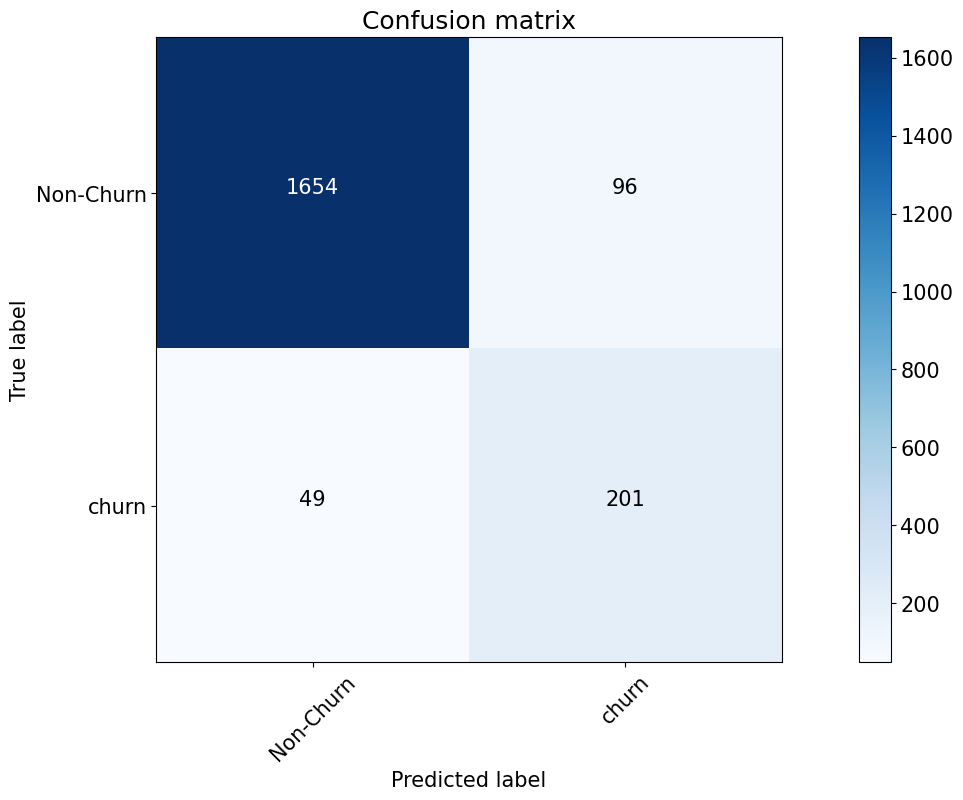

In [73]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(16, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [74]:
roc_auc_score(y_test, preds)

0.9626811428571429

In [75]:
# Добавление значений в массивы

cnf_matrix_arr.append(cnf_matrix)
roc_auc_score_arr.append(roc_auc_score(y_test, preds))

cnf_matrix_arr, roc_auc_score_arr

([array([[1684,   66],
         [  80,  170]]),
  array([[1654,   96],
         [  49,  201]])],
 [0.9593005714285715, 0.9626811428571429])

### Max

In [76]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # можно не среднее
    return user_vector

In [77]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 192 ms, sys: 2.53 ms, total: 194 ms
Wall time: 193 ms


In [78]:
X = pd.merge(user_embeddings, target, 'left')

In [79]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, stratify=X['churn'], 
                                                    test_size=0.25)

In [80]:
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [81]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.06195398, 0.05441389, 0.04239529, 0.02238197, 0.02195121,
       0.06373012, 0.03700945, 0.03371913, 0.00918791, 0.00100035,
       0.00042387, 0.00854559, 0.07343177, 0.01227497, 0.35560159,
       0.07930394, 0.01004765, 0.02169712, 0.01332537, 0.04247148])

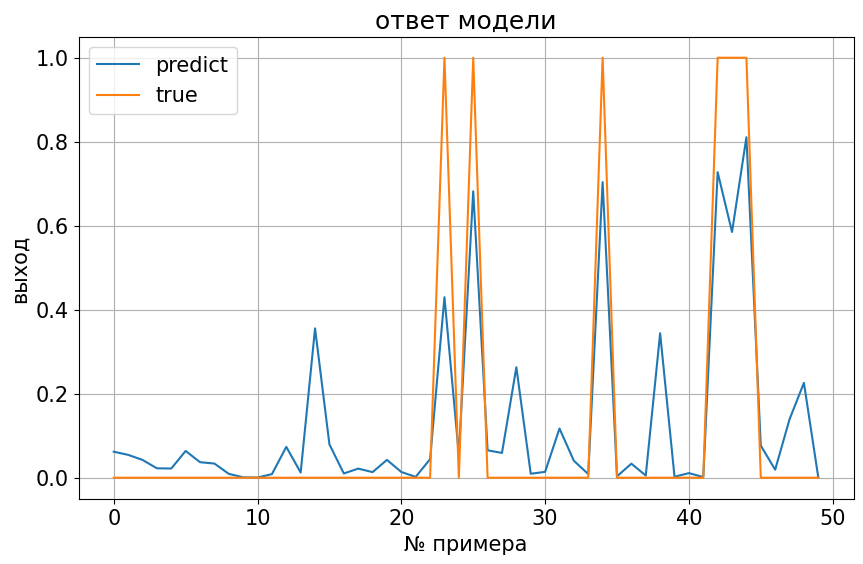

In [82]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [83]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.34420486019287466, F-Score=0.792, Precision=0.770, Recall=0.816


In [84]:
thresholds_arr.append(thresholds[ix])
fscore_arr.append(fscore[ix])
precision_arr.append(precision[ix])
recall_arr.append(recall[ix])

thresholds_arr, fscore_arr, precision_arr, recall_arr

([0.3053607299540598, 0.2752140737806895, 0.34420486019287466],
 [0.7022587268993841, 0.7372262773722629, 0.7922330097087378],
 [0.7215189873417721, 0.6778523489932886, 0.769811320754717],
 [0.684, 0.808, 0.816])

Confusion matrix, without normalization
[[1689   61]
 [  47  203]]


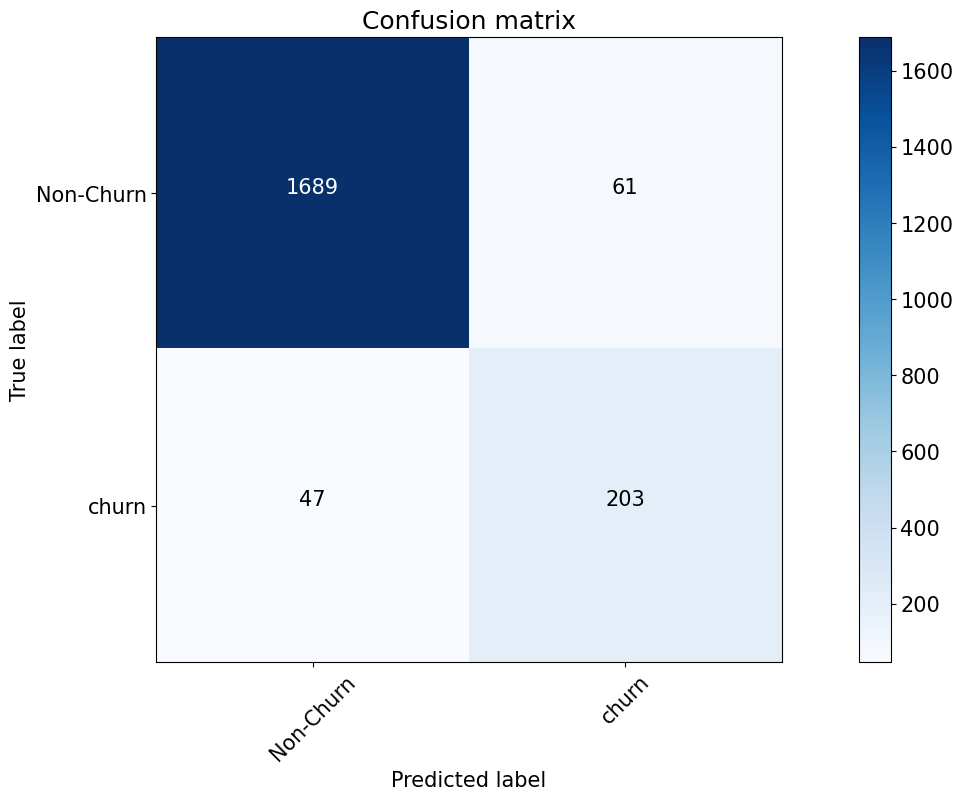

In [85]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(16, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [86]:
roc_auc_score(y_test, preds)

0.9746262857142858

In [87]:
# cnf_matrix

In [88]:
# Добавление значений в массивы

cnf_matrix_arr.append(cnf_matrix)
roc_auc_score_arr.append(roc_auc_score(y_test, preds))

In [89]:
cnf_matrix_arr, roc_auc_score_arr

([array([[1684,   66],
         [  80,  170]]),
  array([[1654,   96],
         [  49,  201]]),
  array([[1689,   61],
         [  47,  203]])],
 [0.9593005714285715, 0.9626811428571429, 0.9746262857142858])

In [90]:
thresholds_arr, fscore_arr, precision_arr, recall_arr, roc_auc_score_arr

([0.3053607299540598, 0.2752140737806895, 0.34420486019287466],
 [0.7022587268993841, 0.7372262773722629, 0.7922330097087378],
 [0.7215189873417721, 0.6778523489932886, 0.769811320754717],
 [0.684, 0.808, 0.816],
 [0.9593005714285715, 0.9626811428571429, 0.9746262857142858])

In [91]:
import pandas as pd
from IPython.display import display

data = {
    'Thresholds': thresholds_arr,
    'Precision': precision_arr,
    'Recall': recall_arr,
    'F-Score': fscore_arr,
    'Confusion Matrix': cnf_matrix_arr,
    'ROC AUC Score': roc_auc_score_arr
}

df = pd.DataFrame(data)

# Замена значений в столбце с индексами
df.index = ['mean', 'median', 'max']

# Установка названия таблицы
print(f'Сравнение методов получения эмбедингов пользователей')

# Вывод таблицы с помощью display
display(df)



Сравнение методов получения эмбедингов пользователей


,Thresholds,Precision,Recall,F-Score,Confusion Matrix,ROC AUC Score
mean,0.305361,0.721519,0.684,0.702259,"[[1684, 66], [80, 170]]",0.959301
median,0.275214,0.677852,0.808,0.737226,"[[1654, 96], [49, 201]]",0.962681
max,0.344205,0.769811,0.816,0.792233,"[[1689, 61], [47, 203]]",0.974626


#### ВЫВОДЫ:
Так как важным является баланс между точностью и полнотой, можно обратить внимание на F-Score. В данном случае, метод MAX имеет наивысший F-Score (0.792), что может указывать на более сбалансированное сочетание точности и полноты.

ROC AUC Score. Здесь метод MAX также имеет наивысшее значение (0.975), что указывает на лучшую способность модели разделять классы.

По матрице ошибок метод "max" показал наименьшее количество ложноотрицательных предсказаний (FN) и ложноположительных предсказаний (FP). Это может свидетельствовать о его способности лучше разделять классы и предсказывать положительные случаи более точно.